In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

In [85]:
df1 = pd.read_csv('dos_goldeneye_attack_dataframe1.csv')
df2 = pd.read_csv('dos_goldeneye_attack_dataframe2.csv')
df3 = pd.read_csv('dos_goldeneye_attack_dataframe3.csv')
df4 = pd.read_csv('dos_goldeneye_attack_dataframe4.csv')
df5 = pd.read_csv('dos_goldeneye_attack_dataframe5.csv')

In [86]:
dosDataframe = pd.concat([df1, df2, df3, df4, df5], axis=0)
dosDataframe = dosDataframe[dosDataframe['Total Length of Fwd Packet'] != 0]
dosDataframe['Dst Port'] = np.random.randint(0, 65536, size=len(dosDataframe))
print(dosDataframe.shape)
dosDataframe.head(5)

(27637, 22)


,Dst Port,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd IAT Total,Bwd IAT Max,...,Packet Length Mean,Packet Length Std,Packet Length Variance,SYN Flag Count,PSH Flag Count,URG Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes
0,61700,491,491,98.2,0,0,0,0,0,0,...,98.2,196.4,38572.96,1,1,0,98.2,98.2,0,0.0
1,52130,465,465,93.0,0,0,0,0,0,0,...,93.0,186.0,34596.00,1,1,0,93.0,93.0,0,232.5
2,23364,487,487,97.4,0,0,0,0,0,0,...,97.4,194.8,37947.04,1,1,0,97.4,97.4,0,243.5
3,13930,512,512,102.4,0,0,0,0,0,0,...,102.4,204.8,41943.04,1,1,0,102.4,102.4,0,256.0
4,10338,557,557,111.4,0,0,0,0,0,0,...,111.4,222.8,49639.84,1,1,0,111.4,111.4,0,278.5


In [87]:
# check for duplicates in the subset of selected features
duplicates_mask = dosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
dosDataframe = dosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {dosDataframe.shape}")

Number of duplicate rows based on selected features: 1
Shape of dataset after removing duplicates: (27636, 22)


In [88]:
dosDataframe['Label'] = 'DoS'
dosDataframe.head(5)

,Dst Port,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd IAT Total,Bwd IAT Max,...,Packet Length Std,Packet Length Variance,SYN Flag Count,PSH Flag Count,URG Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Label
0,61700,491,491,98.2,0,0,0,0,0,0,...,196.4,38572.96,1,1,0,98.2,98.2,0,0.0,DoS
1,52130,465,465,93.0,0,0,0,0,0,0,...,186.0,34596.00,1,1,0,93.0,93.0,0,232.5,DoS
2,23364,487,487,97.4,0,0,0,0,0,0,...,194.8,37947.04,1,1,0,97.4,97.4,0,243.5,DoS
3,13930,512,512,102.4,0,0,0,0,0,0,...,204.8,41943.04,1,1,0,102.4,102.4,0,256.0,DoS
4,10338,557,557,111.4,0,0,0,0,0,0,...,222.8,49639.84,1,1,0,111.4,111.4,0,278.5,DoS


In [2]:
selectedColumns = [
    'Dst Port', 'Total Length of Fwd Packet', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd IAT Total',
    'Bwd IAT Max', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'PSH Flag Count', 'URG Flag Count',
    'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
    'Subflow Fwd Bytes', 'Label'
]

In [3]:
benignDataframe = pd.read_csv('CICIDS_DoS_2.csv')
benignDataframe.columns = benignDataframe.columns.str.strip()

# check for duplicates in the subset of selected features
duplicates_mask = benignDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
benignDataframe = benignDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {benignDataframe.shape}")

benignDataframe = benignDataframe[selectedColumns]
benignDataframe = benignDataframe[benignDataframe['Label'] == 'BENIGN']
benignDataframe = benignDataframe.iloc[:90000]

print(benignDataframe.shape)

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (496641, 91)
(90000, 23)


In [91]:
df = pd.concat([benignDataframe, dosDataframe], ignore_index=True)
df.tail(10) 

,Dst Port,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd IAT Total,Bwd IAT Max,...,Packet Length Std,Packet Length Variance,SYN Flag Count,PSH Flag Count,URG Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Label
117626,26444,422,422,70.333333,0,0,0.0,0.0,0,0,...,157.270114,24733.888889,1,1,0,70.333333,70.333333,0.0,0.000000,DoS
117627,52660,341,341,56.833333,0,0,0.0,0.0,0,0,...,127.083197,16150.138889,1,1,0,56.833333,56.833333,0.0,0.000000,DoS
117628,20204,511,511,85.166667,0,0,0.0,0.0,0,0,...,190.438456,36266.805556,1,1,0,85.166667,85.166667,0.0,0.000000,DoS
117629,19220,357,357,51.000000,0,0,0.0,0.0,0,0,...,124.923977,15606.000000,1,1,0,51.000000,51.000000,0.0,59.500000,DoS
117630,46786,353,353,50.428571,0,0,0.0,0.0,0,0,...,123.524268,15258.244898,1,1,0,50.428571,50.428571,0.0,58.833333,DoS
117631,10898,592,592,84.571429,0,0,0.0,0.0,0,0,...,207.156847,42913.959184,2,1,0,84.571429,84.571429,0.0,98.666667,DoS
117632,9146,673,673,112.166667,0,0,0.0,0.0,0,0,...,250.812291,62906.805556,1,1,0,112.166667,112.166667,0.0,0.000000,DoS
117633,3650,525,525,87.500000,0,0,0.0,0.0,0,0,...,195.655948,38281.250000,1,1,0,87.500000,87.500000,0.0,0.000000,DoS
117634,5968,424,424,70.666667,0,0,0.0,0.0,0,0,...,158.015470,24968.888889,1,1,0,70.666667,70.666667,0.0,0.000000,DoS
117635,55151,447,447,74.500000,0,0,0.0,0.0,0,0,...,166.587064,27751.250000,1,1,0,74.500000,74.500000,0.0,0.000000,DoS


In [92]:
df.shape

(117636, 23)

In [93]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [94]:
# Save the DataFrame to a CSV file
shuffled_df.to_csv('dos_goldeneye.csv', index=False)
print("DataFrame saved to 'dos_goldeneye.csv'")

DataFrame saved to 'dos_goldeneye.csv'


---

In [4]:
scaler = StandardScaler(with_mean=True)

# updated print_confusion_matrix for multi-class classification
def printConfusionMatrix(cm, y_true, normalize=False):
    # get unique class labels
    labels = sorted(set(y_true))

    # visualize the confusion matrix with a heatmap
    plt.figure(figsize=(8, 6))  # set figure size
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


# function to calculate TP, FP, FN, TN for each class
def calculateMetrics(cm):
    """
    Calculate True Positives, False Positives, False Negatives, and True Negatives
    for each class using the confusion matrix.
    """
    metrics = {}
    for classIdx in range(len(cm)):
        tp = cm[classIdx, classIdx]
        fp = cm[:, classIdx].sum() - tp
        fn = cm[classIdx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        metrics[classIdx] = {"TP": tp, "FP": fp, "FN": fn, "TN": tn}
    return metrics


# function to scale specific columns in the data using Standard Scaler
def scaleData(scaler, X_train, X_test, columns_to_scale, fileName = 'standard'):
    # make a copy of the data to avoid modifying the original DataFrame
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # fit and transform the specified columns for X_train
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    # transform only for X_test (using the fit from X_train)
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    joblib.dump(scaler, fileName + '_scaler.pkl')

    # return the scaled dataframes
    return X_train_scaled, X_test_scaled

# function for selecting
def filterBenignValues(dataframe, filterAmount):
    # separate benign rows and non-benign rows
    benign_rows = dataframe[dataframe['Label'] == 'BENIGN']
    non_benign_rows = dataframe[dataframe['Label'] != 'BENIGN']

    # randomly select half of the benign rows
    benign_sample = benign_rows.sample(frac = filterAmount, random_state = 42)  # Adjust random_state for reproducibility

    # combine and return the sampled benign rows with all non-benign rows
    result_df = pd.concat([benign_sample, non_benign_rows])
    return result_df

# function for counting the number of different label types and plotting the result
def count_and_plot(y, labelValues = ['Benign', 'DoS', 'DDoS', 'Port Scanning']):
    # count the number of rows for each label
    labelCounts = y.value_counts().sort_index()

    # calculate additional counts
    countBenign = labelCounts[0] if 0 in labelCounts.index else 0
    countOthers = labelCounts.drop(0).sum() if 0 in labelCounts.index else labelCounts.sum()

    # plot the counts
    plt.figure(figsize=(8, 6))
    plt.bar(labelCounts.index, labelCounts.values, color='skyblue', edgecolor='black')
    plt.xticks(labelCounts.index, labels=[f"{labelValues[lable]}" for lable in labelCounts.index])

    # add labels and show the plot
    plt.xlabel('Label Number')
    plt.ylabel('Number of Rows')
    plt.title(f'Row Counts for Each Label Number\n(Benign: {countBenign}, Others: {countOthers})')
    plt.tight_layout()
    plt.show()

# function for removing null and infi values
def remove_null_and_infi(X_train, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)

    X_train.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)
    X_test.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)

    # ensure no NaN or Inf values remain
    assert not X_train.isnull().any().any(), "X_train still contains NaN values!"
    assert not X_test.isnull().any().any(), "X_test still contains NaN values!"
    assert not (X_train == float('inf')).any().any(), "X_train still contains infinite values!"
    assert not (X_test == float('inf')).any().any(), "X_test still contains infinite values!"

# function for training an SVM model
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, C=1, gamma='scale'):
    # initialize the SVM model with specific C and gamma values
    model = SVC(kernel='rbf', C=C, gamma=gamma) #, class_weight='balanced'
    
    # fit the model
    model.fit(X_train, y_train)

    # predict on the test set
    y_pred = model.predict(X_test)
    
    # calculate train and test accuracy
    trainAccuracy = accuracy_score(y_train, model.predict(X_train))
    testAccuracy = accuracy_score(y_test, y_pred)

    # generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # calculate TP, FP, FN, TN for each class
    metrics = calculateMetrics(cm)

    # generate the classification report
    classReport = classification_report(y_test, y_pred, output_dict=False)

    # print results
    print(f"Train Accuracy: {trainAccuracy:.2f}")
    print(f"Test Accuracy: {testAccuracy:.2f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nMetrics for each class:")
    for classIdx, values in metrics.items():
        print(f"Class {classIdx} -> TP: {values['TP']}, FP: {values['FP']}, FN: {values['FN']}, TN: {values['TN']}")

    print("\nClassification Report:")
    print(classReport)

    # visualize the confusion matrix
    printConfusionMatrix(cm, y_test)

    return model

Number of duplicate rows based on selected features: 61716
Shape of dataset after removing duplicates: (55920, 23)
(39144, 22) (16776, 22) (39144,) (16776,)


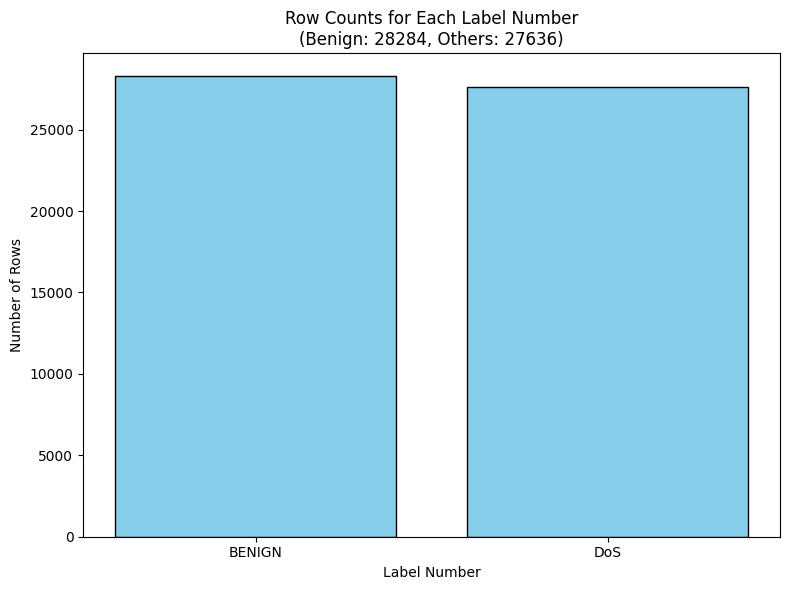

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[8439    2]
 [   0 8335]]

Metrics for each class:
Class 0 -> TP: 8439, FP: 0, FN: 2, TN: 8335
Class 1 -> TP: 8335, FP: 2, FN: 0, TN: 8439

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8441
           1       1.00      1.00      1.00      8335

    accuracy                           1.00     16776
   macro avg       1.00      1.00      1.00     16776
weighted avg       1.00      1.00      1.00     16776



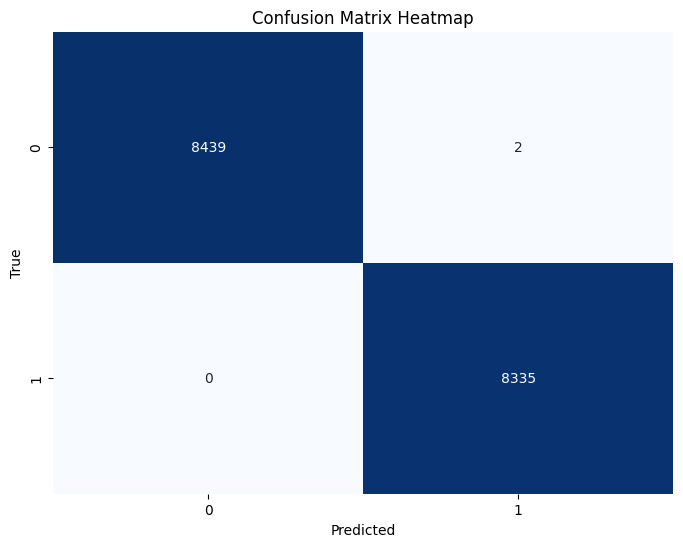

Runtime: 0.01 minutes
Model saved successfully!


In [99]:
dosDataframe = pd.read_csv('dos_goldeneye.csv')

# check for duplicates in the subset of selected features
duplicates_mask = dosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
dosDataframe = dosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {dosDataframe.shape}")

# train-test split
X = dosDataframe.drop(columns=['Label'])
y = dosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS': 1,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'dos_goldeneye')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'dos_goldeneye_svm_model_2.pkl')  
print("Model saved successfully!")

---

## Preparing full DoS dataset

In [144]:
benignDataframe = pd.read_csv('CICIDS_BENIGN_2.csv')
benignDataframe.columns = benignDataframe.columns.str.strip()
benignDataframe = filterBenignValues(benignDataframe, 0.155)
benignDataframe = benignDataframe[selectedColumns]
benignDataframe.shape

(57602, 23)

In [145]:
benignDataframe2 = pd.read_csv('benign_dataset.csv')
benignDataframe2['Label'] = 'BENIGN'
benignDataframe2.shape

(1176, 23)

In [146]:
benignDataframe = pd.concat([benignDataframe, benignDataframe2], axis=0)
benignDataframe = benignDataframe.sample(frac=1, random_state=42).reset_index(drop=True)
benignDataframe.shape

(58778, 23)

In [147]:
df1 = pd.read_csv('dos_goldeneye_attack_dataframe1.csv')
df2 = pd.read_csv('dos_goldeneye_attack_dataframe2.csv')
df3 = pd.read_csv('dos_goldeneye_attack_dataframe3.csv')
df4 = pd.read_csv('dos_goldeneye_attack_dataframe4.csv')
df5 = pd.read_csv('dos_goldeneye_attack_dataframe5.csv')

In [148]:
# Create a new DataFrame with 100k rows, all values set to 0
zerosDF = pd.DataFrame(0, index=range(27000), columns=selectedColumns)

zerosDF['Dst Port'] = np.random.randint(0, 65536, size=len(zerosDF))
zerosDF['SYN Flag Count'] = 1
zerosDF['Bwd IAT Total'] = np.random.uniform(0.05, 2.5, 27000)
zerosDF['Bwd IAT Max'] = np.random.uniform(0.05, 2.5, 27000)
zerosDF['Label'] = 'DoS'

In [149]:
dosDataframe = pd.concat([df1, df2, df3, df4, df5], axis=0)
dosDataframe = dosDataframe[dosDataframe['Total Length of Fwd Packet'] != 0]
dosDataframe['Dst Port'] = np.random.randint(0, 65536, size=len(dosDataframe))
dosDataframe['Label'] = 'DoS'
dosDataframe = pd.concat([dosDataframe, zerosDF], axis=0)
print(dosDataframe.shape)
dosDataframe

(54637, 23)


,Dst Port,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd IAT Total,Bwd IAT Max,...,Packet Length Std,Packet Length Variance,SYN Flag Count,PSH Flag Count,URG Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Label
0,32371,491,491,98.2,0,0,0,0,0.000000,0.000000,...,196.4,38572.96,1,1,0,98.2,98.2,0,0.0,DoS
1,20636,465,465,93.0,0,0,0,0,0.000000,0.000000,...,186.0,34596.00,1,1,0,93.0,93.0,0,232.5,DoS
2,25685,487,487,97.4,0,0,0,0,0.000000,0.000000,...,194.8,37947.04,1,1,0,97.4,97.4,0,243.5,DoS
3,18989,512,512,102.4,0,0,0,0,0.000000,0.000000,...,204.8,41943.04,1,1,0,102.4,102.4,0,256.0,DoS
4,62859,557,557,111.4,0,0,0,0,0.000000,0.000000,...,222.8,49639.84,1,1,0,111.4,111.4,0,278.5,DoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,38719,0,0,0.0,0,0,0,0,0.361827,1.856083,...,0.0,0.00,1,0,0,0.0,0.0,0,0.0,DoS
26996,47460,0,0,0.0,0,0,0,0,0.236757,1.438280,...,0.0,0.00,1,0,0,0.0,0.0,0,0.0,DoS
26997,41023,0,0,0.0,0,0,0,0,0.515599,0.294791,...,0.0,0.00,1,0,0,0.0,0.0,0,0.0,DoS
26998,27149,0,0,0.0,0,0,0,0,2.318534,0.730721,...,0.0,0.00,1,0,0,0.0,0.0,0,0.0,DoS


In [150]:
dosDataframe = pd.concat([dosDataframe, benignDataframe], axis=0)
dosDataframe = dosDataframe.sample(frac=1, random_state=42).reset_index(drop=True)
dosDataframe

,Dst Port,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd IAT Total,Bwd IAT Max,...,Packet Length Std,Packet Length Variance,SYN Flag Count,PSH Flag Count,URG Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Label
0,443,974.0,469,57.294118,1581,0,615.583333,737.165266,3.051000e+05,1.011100e+05,...,548.697100,301068.507389,2,11,0,288.310345,57.294118,615.583333,33.000000,BENIGN
1,23190,0.0,0,0.000000,0,0,0.000000,0.000000,1.069731e+00,2.044635e-01,...,0.000000,0.000000,1,0,0,0.000000,0.000000,0.000000,0.000000,DoS
2,3755,2131.0,734,73.482759,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,...,189.852324,36043.904875,4,4,0,73.482759,73.482759,0.000000,92.652174,DoS
3,3317,0.0,0,0.000000,0,0,0.000000,0.000000,1.145417e+00,2.420145e+00,...,0.000000,0.000000,1,0,0,0.000000,0.000000,0.000000,0.000000,DoS
4,443,1681.0,1348,112.066667,1601,0,446.600000,674.763747,6.032613e+07,1.005377e+07,...,553.952403,306863.264368,2,7,0,279.333333,112.066667,446.600000,56.000000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113410,443,929.0,677,77.416667,805,0,134.714286,300.009286,7.126684e+07,7.116028e+07,...,232.080773,53861.485380,2,7,0,98.526316,77.416667,134.714286,48.000000,BENIGN
113411,53,46.0,46,46.000000,140,140,140.000000,0.000000,0.000000e+00,0.000000e+00,...,66.468037,4418.000000,0,0,0,93.000000,46.000000,140.000000,23.000000,BENIGN
113412,53,56.0,56,56.000000,84,84,84.000000,0.000000,0.000000e+00,0.000000e+00,...,19.798990,392.000000,0,0,0,70.000000,56.000000,84.000000,28.000000,BENIGN
113413,54955,391.0,391,65.166667,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,...,145.717097,21233.472222,1,1,0,65.166667,65.166667,0.000000,0.000000,DoS


(79390, 22) (34025, 22) (79390,) (34025,)


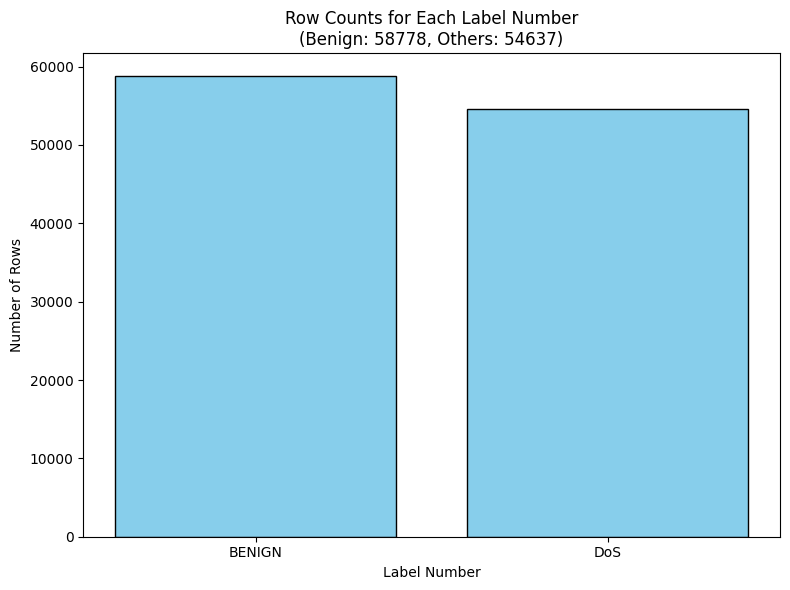

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[17559    79]
 [    0 16387]]

Metrics for each class:
Class 0 -> TP: 17559, FP: 0, FN: 79, TN: 16387
Class 1 -> TP: 16387, FP: 79, FN: 0, TN: 17559

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17638
           1       1.00      1.00      1.00     16387

    accuracy                           1.00     34025
   macro avg       1.00      1.00      1.00     34025
weighted avg       1.00      1.00      1.00     34025



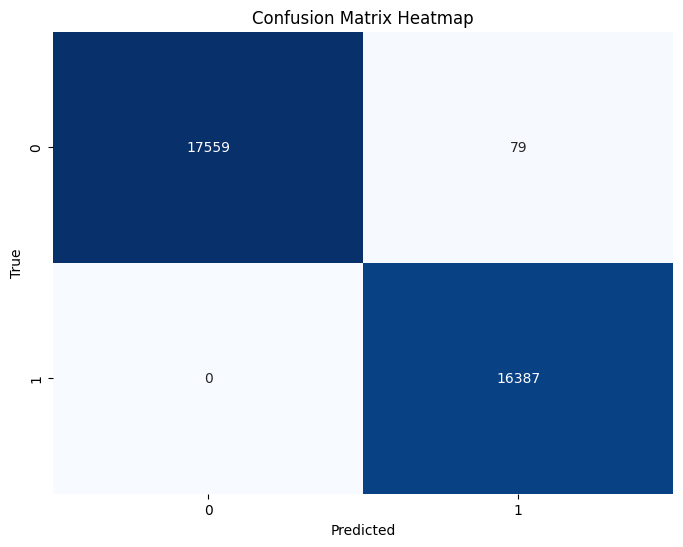

Runtime: 0.21 minutes
Model saved successfully!


In [167]:
# train-test split
X = dosDataframe.drop(columns=['Label'])
y = dosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS': 1,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'full_dos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test, C=0.30, gamma=0.175)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'full_dos_svm_model_2.pkl')  
print("Model saved successfully!")

In [168]:
print("Gamma value:", model._gamma)

Gamma value: 0.175


---

(343527, 82) (147227, 82) (343527,) (147227,)


(490754, 9)

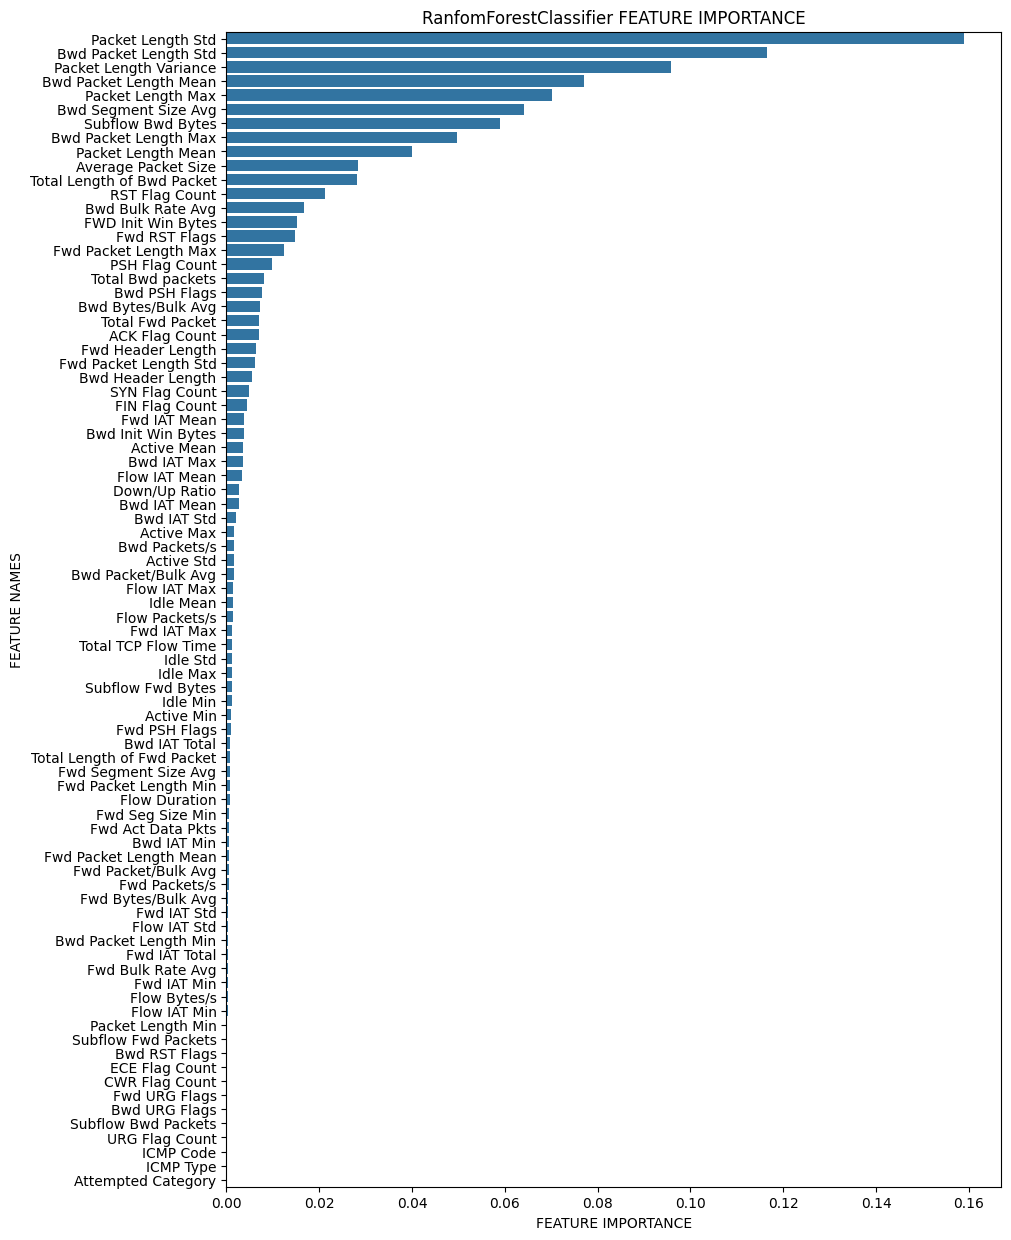

In [15]:
benignDataframe = pd.read_csv('CICIDS_DoS_2.csv')
benignDataframe.columns = benignDataframe.columns.str.strip()
benignDataframe = benignDataframe.drop(columns=['id','Flow ID','Src IP','Src Port','Dst IP','Dst Port','Protocol','Timestamp'])

# # check for duplicates in the subset of selected features
# duplicates_mask = benignDataframe.duplicated(keep='first')
# num_duplicates = duplicates_mask.sum()
# print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# # remove duplicates directly
# benignDataframe = benignDataframe.drop_duplicates(keep='first')
# print(f"Shape of dataset after removing duplicates: {benignDataframe.shape}")

benignDataframe = benignDataframe[(benignDataframe['Label'] == 'BENIGN') | (benignDataframe['Label'] == 'DoS Hulk') | (benignDataframe['Label'] == 'DoS GoldenEye') | (benignDataframe['Label'] == 'DoS Slowloris') | (benignDataframe['Label'] == 'DoS Slowhttptest')]

# train-test split
X = benignDataframe.drop(columns=['Label'])
y = benignDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS Slowloris': 1, 'DoS Slowhttptest': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
featureScores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

featureScores

# create a DataFrame using a Dictionary
data={'feature_names':featureScores.index,'feature_importance':featureScores}
feature_importance = pd.DataFrame(data)

# sort the DataFrame in order decreasing feature importance
feature_importance.sort_values(by=['feature_importance'], ascending=False,inplace=True)

# define size of bar plot
plt.figure(figsize=(10,15))
# plot Searborn bar chart
sns.barplot(x=feature_importance['feature_importance'], y=feature_importance['feature_names'])
# add chart labels
plt.title('RanfomForestClassifier FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

features = featureScores[featureScores >= 0.035].index
df_filtered = X[features]
df_filtered.shape

Number of duplicate rows based on selected features: 177187
Shape of dataset after removing duplicates: (370370, 83)
(191304, 82) (81988, 82) (191304,) (81988,)


(273292, 7)

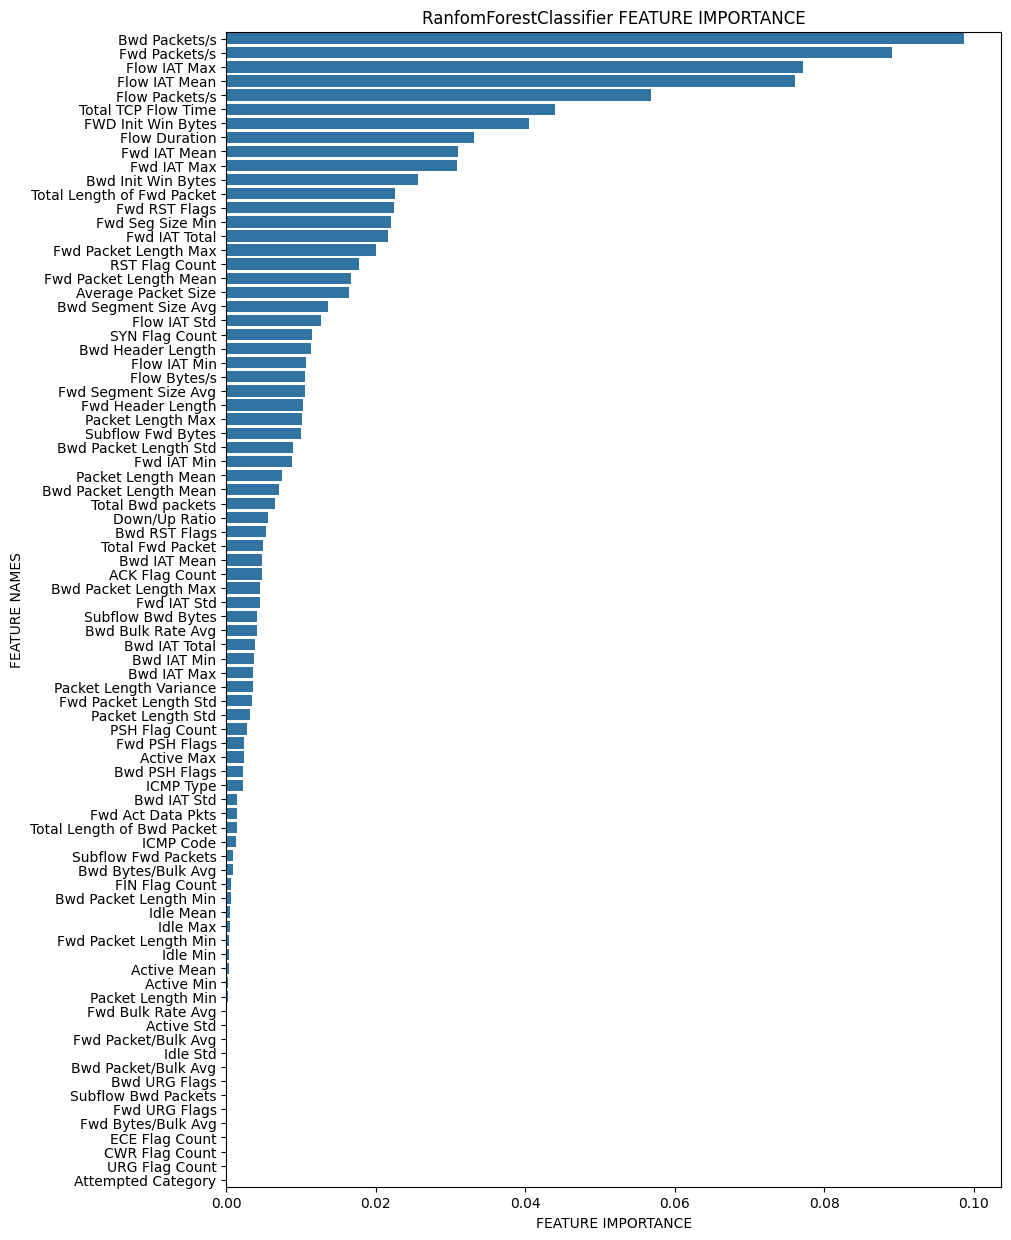

In [16]:
benignDataframe = pd.read_csv('CICIDS_Port_2.csv')
benignDataframe.columns = benignDataframe.columns.str.strip()
benignDataframe = benignDataframe.drop(columns=['id','Flow ID','Src IP','Src Port','Dst IP','Dst Port','Protocol','Timestamp'])

# check for duplicates in the subset of selected features
duplicates_mask = benignDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
benignDataframe = benignDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {benignDataframe.shape}")

benignDataframe = benignDataframe[(benignDataframe['Label'] == 'BENIGN') | (benignDataframe['Label'] == 'Portscan')]

# train-test split
X = benignDataframe.drop(columns=['Label'])
y = benignDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'Portscan': 1,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
featureScores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

featureScores

# create a DataFrame using a Dictionary
data={'feature_names':featureScores.index,'feature_importance':featureScores}
feature_importance = pd.DataFrame(data)

# sort the DataFrame in order decreasing feature importance
feature_importance.sort_values(by=['feature_importance'], ascending=False,inplace=True)

# define size of bar plot
plt.figure(figsize=(10,15))
# plot Searborn bar chart
sns.barplot(x=feature_importance['feature_importance'], y=feature_importance['feature_names'])
# add chart labels
plt.title('RanfomForestClassifier FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

features = featureScores[featureScores >= 0.035].index
df_filtered = X[features]
df_filtered.shape